# Bayesian hypermataparameter optimization for the California housing dataset

In [3]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing as fch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load dataset
california_housing = fch()

X = california_housing.data
y = california_housing.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                	test_size=0.3,
                                                	random_state=2024)

In [5]:
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (14448, 8)
Testing Shape: (6192, 8)


In [6]:
# Parameter grid
param_dist = {
    'max_depth': [3, 10, 5, 15],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_reg, param_distributions=param_dist, n_iter=25,
    scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters
print("Random Search Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Random Search Best Parameters: {'subsample': 0.5, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [7]:
# Parameter bounds
baysian_opt_bounds = [
    {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 10, 5, 15)},
    {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 5, 10)},
    {'name': 'subsample', 'type': 'continuous', 'domain': (0.5, 1.0)},
    {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0.5, 1.0)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (100, 200, 300, 400)},
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.01, 0.2)}
]

# Objective function
def xgb_cv_score(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                xgb.XGBRegressor(
                    max_depth=int(parameters[0]),
                    min_child_weight=int(parameters[1]),
                    subsample=parameters[2],
                    colsample_bytree=parameters[3],
                    n_estimators=int(parameters[4]),
                    learning_rate=parameters[5]), 
                X_train, y_train, scoring='neg_mean_squared_error', cv=3).mean()
    return score

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_cv_score, domain=baysian_opt_bounds, model_type='GP',
    acquisition_type='EI', max_iter=25
)
optimizer.run_optimization()

# Best parameters
best_params_bayesian = {k: int(v) if k in ['max_depth', 'min_child_weight', 'n_estimators'] else v for k, v in zip(['max_depth', 'min_child_weight', 'subsample', 'colsample_bytree', 'n_estimators', 'learning_rate'], optimizer.x_opt)}

print("Bayesian Optimization Best Parameters:", best_params_bayesian)

Bayesian Optimization Best Parameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7784017988015777, 'colsample_bytree': 0.8279374814554374, 'n_estimators': 200, 'learning_rate': 0.10935251961682875}


In [8]:
params_random_search = {
                        'subsample': 0.5, 
                        'n_estimators': 400, 
                        'min_child_weight': 5, 
                        'max_depth': 10, 
                        'learning_rate': 0.05, 
                        'colsample_bytree': 1.0
                       }

# Initialize and train the model
model_random_search = xgb.XGBRegressor(**params_random_search)
model_random_search.fit(X_train, y_train)

# Make predictions and evaluate
predictions_random_search = model_random_search.predict(X_test)
mse_random_search = mean_squared_error(y_test, predictions_random_search)
print("MSE for Random Search: ", mse_random_search)

MSE for Random Search:  0.22042313924570814


In [9]:
# Hyperparameters from Bayesian Optimization
params_bayesian_opt = {
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.820222997732141,
    'colsample_bytree': 0.6710357796023916,
    'n_estimators': 300,
    'learning_rate': 0.04797554348030097
}

# Initialize and train the model
model_bayesian_opt = xgb.XGBRegressor(**params_bayesian_opt)
model_bayesian_opt.fit(X_train, y_train)

# Make predictions and evaluate
predictions_bayesian_opt = model_bayesian_opt.predict(X_test)
mse_bayesian_opt = mean_squared_error(y_test, predictions_bayesian_opt)
print("MSE for Bayesian Optimization: ", mse_bayesian_opt)

MSE for Bayesian Optimization:  0.20280490406646876


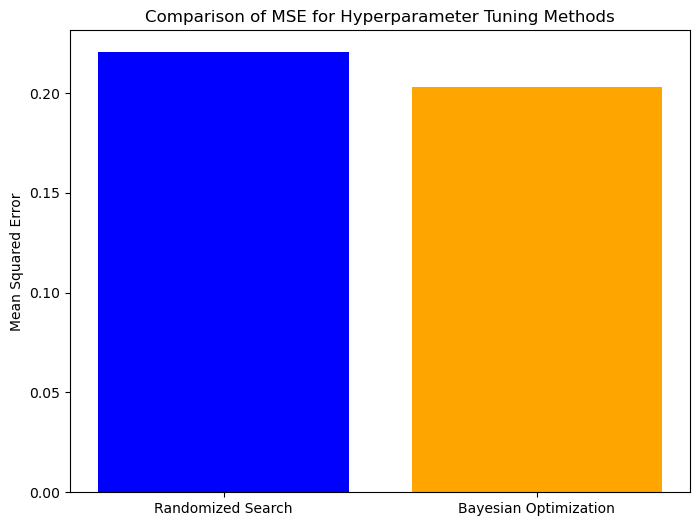

In [10]:
# Comparar MSE
methods = ['Randomized Search', 'Bayesian Optimization']
mse_values = [mse_random_search, mse_bayesian_opt]

plt.figure(figsize=(8, 6))
plt.bar(methods, mse_values, color=['blue', 'orange'])
plt.ylabel("Mean Squared Error")
plt.title("Comparison of MSE for Hyperparameter Tuning Methods")
plt.show()


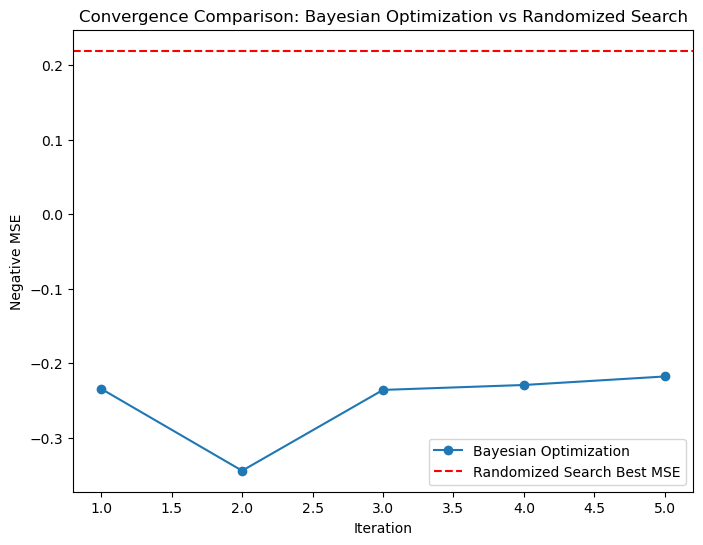

In [11]:
plt.figure(figsize=(8, 6))

# Convergencia de Bayesian Optimization
plt.plot(range(1, len(optimizer.Y) + 1), -optimizer.Y, marker='o', label='Bayesian Optimization')

# Mejor MSE de Randomized Search como línea horizontal
plt.axhline(y=-random_search.best_score_, color='r', linestyle='--', label='Randomized Search Best MSE')

# Etiquetas y leyenda
plt.xlabel("Iteration")
plt.ylabel("Negative MSE")
plt.title("Convergence Comparison: Bayesian Optimization vs Randomized Search")
plt.legend()
plt.show()


-----

Training Shape: (14448, 8)
Testing Shape: (6192, 8)
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Random Search Results:
Best Params: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
MSE: 0.2164
Time: 96.72 seconds

Bayesian Optimization Results:
Best Params: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 300, 'learning_rate': 0.1}
MSE: 0.2126
Time: 0.10 seconds


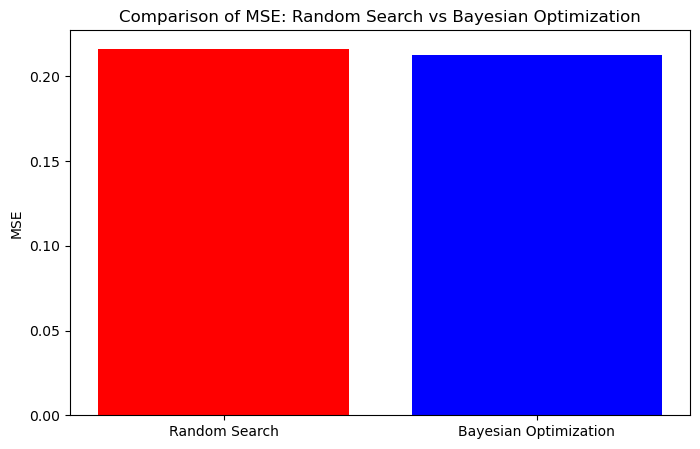

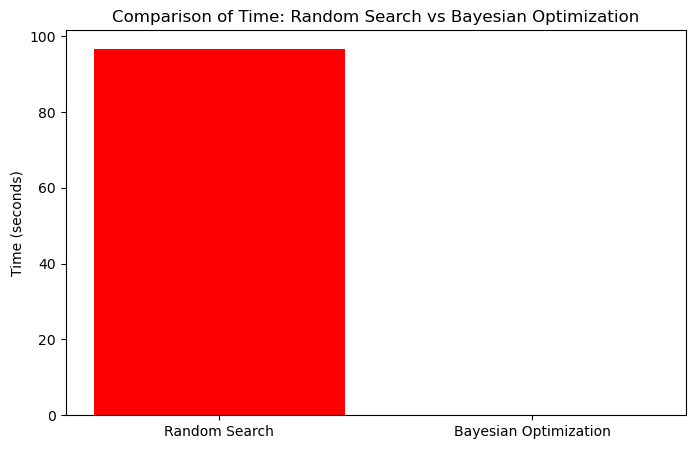

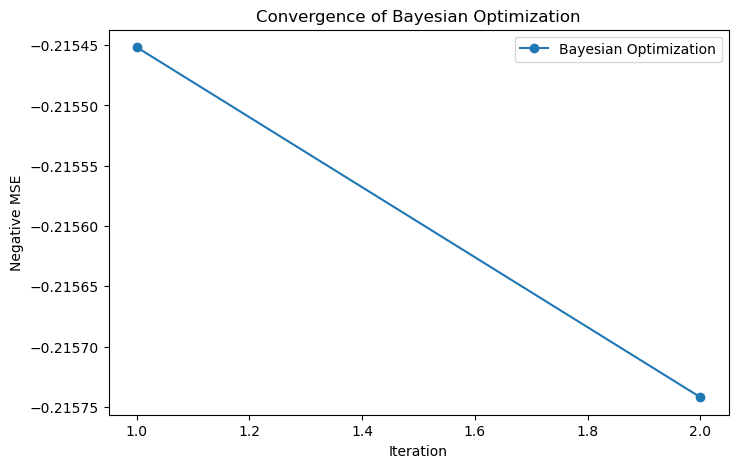

In [14]:
import time
import xgboost as xgb
from sklearn.datasets import fetch_california_housing as fch
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from GPyOpt.methods import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset California Housing
california_housing = fch()
X = california_housing.data
y = california_housing.target

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

# ---- RANDOMIZED SEARCH ----
# Espacio de búsqueda para Randomized Search
param_dist = {
    'max_depth': [3, 5, 10, 15],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Ejecutar Randomized Search
start_random = time.time()
xgb_reg = xgb.XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(
    xgb_reg, param_distributions=param_dist, n_iter=25,
    scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42
)
random_search.fit(X_train, y_train)
end_random = time.time()

# Obtener resultados de Randomized Search
best_params_random = random_search.best_params_
mse_random = mean_squared_error(y_test, random_search.best_estimator_.predict(X_test))
time_random = end_random - start_random

# ---- BAYESIAN OPTIMIZATION ----
# Espacio de búsqueda para Bayesian Optimization
baysian_opt_bounds = [
    {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 5, 10, 15)},
    {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 5, 10)},
    {'name': 'subsample', 'type': 'continuous', 'domain': (0.5, 1.0)},
    {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0.5, 1.0)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (100, 200, 300, 400)},
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.01, 0.2)}
]

# Configuraciones iniciales para guiar la optimización
X_init = np.array([
    [10, 5, 0.8, 0.8, 300, 0.1],
    [8, 3, 0.7, 0.9, 200, 0.05]
])
Y_init = np.array([
    -cross_val_score(
        xgb.XGBRegressor(
            max_depth=10, min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
            n_estimators=300, learning_rate=0.1, random_state=42
        ),
        X_train, y_train, scoring='neg_mean_squared_error', cv=3
    ).mean(),
    -cross_val_score(
        xgb.XGBRegressor(
            max_depth=8, min_child_weight=3, subsample=0.7, colsample_bytree=0.9,
            n_estimators=200, learning_rate=0.05, random_state=42
        ),
        X_train, y_train, scoring='neg_mean_squared_error', cv=3
    ).mean()
])
Y_init = Y_init.reshape(-1, 1)  # Convertir a forma (n_samples, 1)

# Función objetivo para Bayesian Optimization
def xgb_cv_score(parameters):
    try:
        parameters = parameters[0]
        model = xgb.XGBRegressor(
            max_depth=int(parameters[0]),
            min_child_weight=int(parameters[1]),
            subsample=parameters[2],
            colsample_bytree=parameters[3],
            n_estimators=int(parameters[4]),
            learning_rate=parameters[5],
            random_state=42
        )
        score = -cross_val_score(
            model, X_train, y_train,
            scoring='neg_mean_squared_error',
            cv=3
        ).mean()
        return score
    except Exception as e:
        print(f"Error with parameters {parameters}: {e}")
        return 1e6  # Penalización alta

# Ejecutar Bayesian Optimization
start_bayesian = time.time()
optimizer = BayesianOptimization(
    f=xgb_cv_score,
    domain=baysian_opt_bounds,
    model_type='GP',  # Modelo de proceso gaussiano
    acquisition_type='EI',  # Expected Improvement
    X=X_init,  # Configuraciones iniciales
    Y=Y_init,  # Resultados iniciales
    max_iter=25,  # Iteraciones máximas
)
optimizer.run_optimization()
end_bayesian = time.time()

# Obtener resultados de Bayesian Optimization
best_params_bayesian = {
    'max_depth': int(optimizer.x_opt[0]),
    'min_child_weight': int(optimizer.x_opt[1]),
    'subsample': optimizer.x_opt[2],
    'colsample_bytree': optimizer.x_opt[3],
    'n_estimators': int(optimizer.x_opt[4]),
    'learning_rate': optimizer.x_opt[5]
}
model_bayesian = xgb.XGBRegressor(**best_params_bayesian, random_state=42)
model_bayesian.fit(X_train, y_train)
mse_bayesian = mean_squared_error(y_test, model_bayesian.predict(X_test))
time_bayesian = end_bayesian - start_bayesian

# ---- COMPARACIÓN ----
print("\nRandom Search Results:")
print(f"Best Params: {best_params_random}")
print(f"MSE: {mse_random:.4f}")
print(f"Time: {time_random:.2f} seconds")

print("\nBayesian Optimization Results:")
print(f"Best Params: {best_params_bayesian}")
print(f"MSE: {mse_bayesian:.4f}")
print(f"Time: {time_bayesian:.2f} seconds")

# ---- GRÁFICAS ----
# Gráfica de MSE
plt.figure(figsize=(8, 5))
methods = ['Random Search', 'Bayesian Optimization']
mse_values = [mse_random, mse_bayesian]
plt.bar(methods, mse_values, color=['red', 'blue'])
plt.ylabel("MSE")
plt.title("Comparison of MSE: Random Search vs Bayesian Optimization")
plt.show()

# Gráfica de tiempos
plt.figure(figsize=(8, 5))
time_values = [time_random, time_bayesian]
plt.bar(methods, time_values, color=['red', 'blue'])
plt.ylabel("Time (seconds)")
plt.title("Comparison of Time: Random Search vs Bayesian Optimization")
plt.show()

# Gráfica de convergencia de Bayesian Optimization
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(optimizer.Y) + 1), -optimizer.Y, marker='o', label='Bayesian Optimization')
plt.xlabel("Iteration")
plt.ylabel("Negative MSE")
plt.title("Convergence of Bayesian Optimization")
plt.legend()
plt.show()
